# Trackfile original

## Imports

In [1]:
import kdsource.histograms as kdh
import kdsource.surfsource as kds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Sequence, Tuple, List, Union

plt.rcParams["figure.figsize"] = (15, 2.5)


def plot_pairwise_matrix(
    surface_source,
    vars_list: List[str],
    bins: Union[int, List[int]] = 100,
    *,
    xscale: str = "linear",
    yscale: str = "log",
    zscale: str = "log",
    figsize: Tuple[int, int] | None = None,
    plot_difference: bool = False,
    Difference_to: str = None,
    cheap: bool = True,
) -> Tuple[plt.Figure, List[List[plt.Axes]]]:
    """Draw an *n×n* matrix of distributions for every pair of variables.

    The matrix contains

    * **Diagonal** – 1-D histograms of each variable
      (`plot_distribution(vars=[v], …)`).

    * **Off-diagonals** – 2-D colour-map histograms for every
      ordered pair *(vᵢ, vⱼ)*
      (`plot_distribution(vars=[vᵢ, vⱼ], …, zscale='log')`).

    Parameters
    ----------
    surface_source
        Instance of ``kdsource.SurfaceSourceFile`` that already has the
        particles loaded.
    vars_list : list[str]
        Ordered list of variables to plot, e.g.
        ``["ln(E0/E)", "x", "y", "mu", "phi"]``.
    bins : int | list[int], default **100**
        Bin count (scalar) or per-variable list passed straight to
        ``plot_distribution``.
    xscale : {'linear', 'log'}, default **'linear'**
        Scale used for every *x-axis* in the matrix.
    yscale : {'linear', 'log'}, default **'log'**
        Scale used for every *y-axis* (and 1-D histogram counts).
    zscale : {'linear', 'log'}, default **'log'**
        Colour-bar scale for all 2-D plots.
    figsize : tuple[int, int] | None
        Figure size in inches.  Defaults to *(4 × n, 4 × n)*.

    Returns
    -------
    fig, axes
        The created ``matplotlib`` figure and its *n×n* axes matrix.

    Notes
    -----
    *Internally* uses ``plt.sca(ax)`` before calling
    ``surface_source.plot_distribution(..)`` so that the plot is drawn
    in the proper cell (``plot_distribution`` always acts on the current
    axis) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}.

    All 2-D plots receive ``zscale=log`` as requested :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}.
    """
    n = len(vars_list)
    if figsize is None:
        figsize = (4 * n, 4 * n)

    fig, axes = plt.subplots(n, n, figsize=figsize, squeeze=False)

    # Ensure ``bins`` is a list the same length as ``vars_list``.
    if isinstance(bins, int):
        bins = [bins] * len(vars_list)

    for i, var_i in enumerate(vars_list):
        for j, var_j in enumerate(vars_list):
            if j < i:
                if cheap:
                    continue
            ax = axes[i][j]
            plt.sca(ax)  # make this axes current
            ax.grid(True)  # add grid lines

            if i == j:
                # Diagonal: 1-D histogram
                surface_source.plot_distribution(
                    vars=[var_i],
                    bins=[bins[i]],
                    scales=[xscale, yscale],
                    plot_difference=plot_difference,
                    Difference_to=Difference_to,
                )
            else:
                # Off-diagonal: 2-D histogram
                surface_source.plot_distribution(
                    vars=[var_j, var_i],  # x = var_j, y = var_i
                    bins=[bins[j], bins[i]],
                    scales=[xscale, xscale],
                    zscale=zscale,
                    plot_difference=plot_difference,
                    Difference_to=Difference_to,
                )

            # Cosmetic tweaks: remove redundant tick labels
            if i < n - 1:
                ax.set_xlabel("")
            if j > 0:
                ax.set_ylabel("")
            if i != j:
                ax.set_title("")  # avoid clutter

    plt.tight_layout()
    return fig, axes


def plot_comparision_1D(
    vars,
    trackfile_original=None,
    trackfile_resampled=None,
    save=False,
    right_xlim=None,
    bins=500,
    fig_name=None,
    height_ratios=[2.5, 1],
    hspace=0.3,
    figsize=(12, 6),
):

    from matplotlib.gridspec import GridSpec

    # Crear figura y gridspec con altura relativa 2.5 para el primer plot y 1 para el segundo
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 1, height_ratios=height_ratios, hspace=hspace)

    # Plot 1: distribuciones
    ax1 = fig.add_subplot(gs[0])
    trackfile_original.plot_distribution(
        vars=[vars],
        bins=[bins],
        scales=["linear", "log"],
        label="Archivo original",
    )
    trackfile_resampled.plot_distribution(
        vars=[vars],
        bins=[bins],
        scales=["linear", "log"],
        label="Archivo original",
    )
    ax1.grid()
    ax1.set_ylabel("Frecuencia")
    ax1.legend()
    if right_xlim is not None:
        ax1.set_xlim(right=right_xlim)

    # Plot 2: diferencia relativa
    ax2 = fig.add_subplot(gs[1])
    trackfile_original.plot_distribution(
        vars=[vars],
        bins=[bins],
        scales=["linear", "linear"],
        plot_difference=True,
        Difference_to=trackfile_resampled,
    )
    ax2.grid()
    ax2.set_ylim(0, 100)

    if right_xlim is not None:
        ax2.set_xlim(right=right_xlim)

    plt.show()
    if save:
        plt.savefig(fig_name, dpi=600, bbox_inches="tight")

    # plt.close(fig)


def plot_comparation_2d(
    source,
    resampled,
    vars: List[str],
    bins: int,
    scales: List[str] = ["linear", "linear"],
):

    plt.figure()
    source.plot_distribution(
        vars=vars,
        bins=[bins, bins],
        scales=scales,
        zscale="log",
        plot_difference=True,
        Difference_to=resampled,
    )
    plt.show()


from itertools import combinations
from typing import Iterable, Mapping


# -----------------------------------------------------------------------------
# Helper genérico: KL sobre vectores de conteos (pseudoconteo incluido)
# -----------------------------------------------------------------------------
def _kl_counts(counts_p, counts_q, smooth: float = 1e-9) -> float:
    # Convierte a float para evitar errores en divisiones
    p = counts_p.astype(float)
    q = counts_q.astype(float)
    # Normaliza después del smooth (solo en q)
    mask = p > 0  # Solo lugares donde p es distinto de cero
    q[mask] += smooth
    # Normalización solo sobre los bines considerados
    p_sum = p[mask].sum()
    q_sum = q[mask].sum()
    p_norm = p[mask] / p_sum if p_sum != 0 else np.zeros_like(p[mask])
    q_norm = q[mask] / q_sum if q_sum != 0 else np.zeros_like(q[mask])
    ratio = np.where(p_norm >= q_norm, p_norm / q_norm, q_norm / p_norm)
    # Cálculo de KL solo sobre el soporte de p
    # kl = np.sum(p_norm * np.log(p_norm / q_norm))
    kl = np.sum(p_norm * np.log(ratio))
    return float(kl)


# -----------------------------------------------------------------------------
# Función principal
# -----------------------------------------------------------------------------
def report_kl_divergence(
    ss_original,
    ss_resampled,
    variables: Iterable[str],
    *,
    n_bins: int = 1_000,
    smooth: float = 0.5,
    quiet: bool = False,
) -> Mapping[str, Mapping]:
    """KL 1-D y 2-D (todas las parejas) entre dos SurfaceSourceFile.

    Returns
    -------
    result : dict
        {
          "kl_1d":   {var: kl, ...},
          "kl_2d":   {"var1,var2": kl, ...},
          "total_1d": float,
          "total_2d": float,
          "total_all": float
        }
    """
    df_p = ss_original.get_pandas_dataframe()
    df_q = ss_resampled.get_pandas_dataframe()

    vars_list = list(variables)
    kl_1d, kl_2d = {}, {}
    total_1d = total_2d = 0.0

    # ---------- 1-D ----------------------------------------------------------
    for var in vars_list:
        if var not in df_p.columns or var not in df_q.columns:
            raise KeyError(f"Variable '{var}' no existe en ambos DataFrames")

        vmin = min(df_p[var].min(), df_q[var].min())
        vmax = max(df_p[var].max(), df_q[var].max())
        bins = np.linspace(vmin, vmax, n_bins + 1)

        cnt_p, _ = np.histogram(df_p[var], bins=bins)
        cnt_q, _ = np.histogram(df_q[var], bins=bins)

        kl = _kl_counts(cnt_p, cnt_q, smooth)
        kl_1d[var] = kl
        total_1d += kl

        if not quiet:
            print(f"KL 1D[{var}] = {kl:.4e}")

    # ---------- 2-D (todas las parejas) -------------------------------------
    for var_x, var_y in combinations(vars_list, 2):
        # rangos independientes por eje
        vx_min = min(df_p[var_x].min(), df_q[var_x].min())
        vx_max = max(df_p[var_x].max(), df_q[var_x].max())
        vy_min = min(df_p[var_y].min(), df_q[var_y].min())
        vy_max = max(df_p[var_y].max(), df_q[var_y].max())

        x_bins = np.linspace(vx_min, vx_max, n_bins + 1)
        y_bins = np.linspace(vy_min, vy_max, n_bins + 1)

        H_p, _, _ = np.histogram2d(df_p[var_x], df_p[var_y], bins=[x_bins, y_bins])
        H_q, _, _ = np.histogram2d(df_q[var_x], df_q[var_y], bins=[x_bins, y_bins])

        kl = _kl_counts(H_p.ravel(), H_q.ravel(), smooth)
        key = f"{var_x},{var_y}"
        kl_2d[key] = kl
        total_2d += kl

        if not quiet:
            print(f"KL 2D[{key}] = {kl:.4e}")

    total_all = total_1d + total_2d
    if not quiet:
        print("-" * 50)
        print(f"Σ KL 1-D = {total_1d:.4e}  |  Σ KL 2-D = {total_2d:.4e}")
        print(f"KL total  = {total_all:.4e} (1D + 2D)")

    return {
        "kl_1d": kl_1d,
        "kl_2d": kl_2d,
        "total_1d": total_1d,
        "total_2d": total_2d,
        "total_all": total_all,
    }

## Configuracion

In [2]:
hs = kdh.HistogramSource(
    trackfile="/home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/surface_source.h5",
    particle_type="neutron",
    z0=15,
    Nparticles=5e4,
    # surface_geometry="circular",
    # R=5,
    domain={"w": [0, 2]},
)

[DEBUG] Creando SurfaceSourceFile con domain={'w': [0, 2], 'type': [2112, None]}
[DEBUG] Σwgt=4.525e+03 | N=50000 | J=9.049e-02


Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/surface_source.h5: 61366
100% n, 0% g, 0% e-, 0% e+, 0% p, 


In [3]:
hs.configure_binning(
    variable_order=["ln(E0/E)", "x", "y", "mu", "phi"],
    micro_bins=[36] * 5,
    # micro_bins=[50, 10, 10, 10, 10],
    # macro_bins=[6] * 4,
    macro_bins=[4, 3, 3, 4],
    micro_initial_bins=[1] * 5,
    # micro_initial_bins=[None,1,1,None,None],
    macro_initial_bins=[1] * 4,
    # macro_initial_bins=[1,2,2,None,None],
    user_macro_edges=[
        [2.995732273553991 + 1e-9],
        [-1.5, 1.5],
        [-1.5, 1.5],
        [1 - 1e9],
        None,
    ],
    micro_binning="equal_bins",
    macro_binning="equal_bins",
)

hs.build_tree()

hs.write_xml(output="source.xml")

hs.generate_mcpl(
    # n_particles=5e6,
    n_particles=1e7,
    write_path="trackfile1.mcpl",
    overwrite=True,
)

[DEBUG] Binning configurado → {'order': ['ln(E0/E)', 'x', 'y', 'mu', 'phi'], 'micro': [36, 36, 36, 36, 36], 'macro': [4, 3, 3, 4], 'micro_initial_bins': [1, 1, 1, 1, 1], 'macro_initial_bins': [1, 1, 1, 1], 'micro_binning': 'equal_bins', 'macro_binning': 'equal_bins', 'user': [[2.995732274553991], [-1.5, 1.5], [-1.5, 1.5], [-999999999.0], None]}
[DEBUG] Árbol construido con éxito. Root=TreeNode(n_children=6)
[INFO] XML guardado → source.xml
[INFO] Ejecutando: kdtool resample -o /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/config7/trackfile1.mcpl -n 10000000 -m 2 /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/config7/source.xml


KDSource resample tool
flag1
Resampling from histograms...
Header loaded successfully
Variables = 5 | z0 = 15.000 cm | J = 9.049e-02 1/s
 | Geometry = rectangular
Particula 100000
Particula 200000
Particula 300000
Particula 400000
Particula 500000
Particula 600000
Particula 700000
Particula 800000
Particula 900000
Particula 1000000
Particula 1100000
Particula 1200000
Particula 1300000
Particula 1400000
Particula 1500000
Particula 1600000
Particula 1700000
Particula 1800000
Particula 1900000
Particula 2000000
Particula 2100000
Particula 2200000
Particula 2300000
Particula 2400000
Particula 2500000
Particula 2600000
Particula 2700000
Particula 2800000
Particula 2900000
Particula 3000000
Particula 3100000
Particula 3200000
Particula 3300000
Particula 3400000
Particula 3500000
Particula 3600000
Particula 3700000
Particula 3800000
Particula 3900000
Particula 4000000
Particula 4100000
Particula 4200000
Particula 4300000
Particula 4400000
Particula 4500000
Particula 4600000
Particula 4700000


[INFO] MCPL generado → /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/config7/trackfile1.mcpl


MCPL: Succesfully compressed file into trackfile1.mcpl.gz
Successfully sampled 10000000 particles.


PosixPath('/home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile5/config7/trackfile1.mcpl')

In [4]:
# bins = 75
# plt.figure(figsize=(8, 8))
# hs.surface_source.plot_distribution(
#     vars=["x", "y"],
#     bins=[bins, bins],
#     scales=["linear", "linear"],
#     zscale="log",
#     zlabel="Intensidad",
# )
# plt.gca().set_aspect("equal", adjustable="box")  # Hace el plot cuadrado
# # plt.savefig("fig4_1.png", dpi=600, bbox_inches="tight")
# plt.show()

# plt.figure(figsize=(12, 6))
# hs.surface_source.plot_distribution(
#     vars=["ln(E0/E)", "mu"],
#     bins=[bins, bins],
#     scales=["linear", "linear"],
#     zscale="log",
#     zlabel="Intensidad",
# )
# # plt.gca().set_aspect('equal', adjustable='box')  # Hace el plot cuadrado
# # plt.savefig("fig4_3.png", dpi=600, bbox_inches="tight")
# plt.show()

## Ploteos de la distribucion original

### Ploteos 1D

In [5]:
# bins = 250
# # %matplotlib widget
# plt.figure(figsize=(15, 3.75))
# plt.subplot(1, 2, 1)
# hs.surface_source.plot_distribution(
#     vars=["ln(E0/E)"],
#     bins=[bins],
#     scales=["linear", "log"],
#     ylabel="Frecuencia",
# )
# plt.grid()
# plt.subplot(1, 2, 2)
# hs.surface_source.plot_distribution(
#     vars=["mu"],
#     bins=[bins],
#     scales=["linear", "log"],
#     ylabel="Frecuencia",
# )
# plt.grid()
# # plt.savefig("fig4_2.png", dpi=600, bbox_inches="tight")
# plt.show()

# plt.figure()
# hs.surface_source.plot_distribution(
#     vars=["y"],
#     bins=[bins],
#     scales=["linear", "log"],
# )
# plt.grid()
# plt.show()


# plt.figure()
# hs.surface_source.plot_distribution(
#     vars=["phi"],
#     bins=[bins],
#     scales=["linear", "log"],
# )
# plt.grid()
# plt.show()

### Ploteos 2D

In [6]:
# # %matplotlib widget
# plt.close("all")
# # plt.figure()
# # hs.surface_source.plot_distribution(
# #     vars=["x", "ln(E0/E)"],
# #     bins=[bins, bins],
# #     scales=["linear", "linear"],
# #     zscale="log",
# #     zlabel="Intensidad",
# # )
# # plt.show()

# # plt.figure()
# # hs.surface_source.plot_distribution(
# #     vars=["x", "y"],
# #     bins=[bins, bins],
# #     scales=["linear", "linear"],
# #     zscale="log",
# #     zlabel="Intensidad",
# # )
# # plt.show()
# # plt.close("all")

# # plt.figure()
# # hs.surface_source.plot_distribution(
# #     vars=["x", "mu"],
# #     bins=[bins, bins],
# #     scales=["linear", "linear"],
# #     zscale="log",
# #     zlabel="Intensidad",
# # )
# # plt.show()

# bins = 75

# plt.figure()
# hs.surface_source.plot_distribution(
#     vars=["ln(E0/E)", "mu"],
#     bins=[bins, bins],
#     scales=["linear", "linear"],
#     zscale="log",
#     zlabel="Intensidad",
# )
# plt.show()

### Ploteo nxn

In [7]:
# # %matplotlib widget
vars_to_plot = ["ln(E0/E)", "x", "y", "mu", "phi"]
# fig, ax_matrix = plot_pairwise_matrix(
#     hs.surface_source, vars_to_plot, bins=50,figsize=(18, 8)
# )
# plt.savefig("original_matrix.png", dpi=600, bbox_inches="tight")
# plt.show()



# Trackfile resampleado

In [8]:
trackfile_resampled = kds.SurfaceSourceFile(
    filepath="trackfile1.mcpl.gz",
)
trackfile_resampled._Np = hs.surface_source._Np * trackfile_resampled._df2["wgt"].sum() / hs.surface_source._df2["wgt"].sum()

Number of particles in file trackfile1.mcpl.gz: 10000000
100% n, 0% g, 0% e-, 0% e+, 0% p, 


## Ploteo de la distribucion sampleada

### Ploteo 1D

In [9]:
# bins = 250
# %matplotlib widget
# plt.figure()
# trackfile_resampled.plot_distribution(
#     vars=["ln(E0/E)"],
#     bins=[bins],
#     scales=["linear", "log"],
# )
# plt.grid()
# plt.show()

# plt.figure()
# trackfile_resampled.plot_distribution(
#     vars=["x"],
#     bins=[bins],
#     scales=["linear", "log"],
# )
# plt.grid()
# plt.show()

# plt.figure()
# trackfile_resampled.plot_distribution(
#     vars=["y"],
#     bins=[bins],
#     scales=["linear", "log"],
# )
# plt.grid()
# plt.show()

### Ploteo 2D

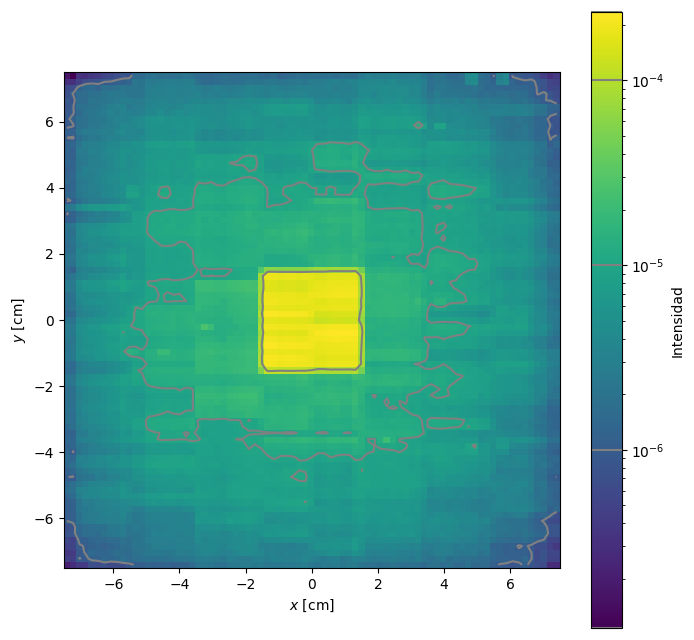

In [10]:
bins = 80
plt.figure(figsize=(8, 8))
trackfile_resampled.plot_distribution(
    vars=["x", "y"],
    bins=[bins, bins],
    scales=["linear", "linear"],
    zscale="log",
    zlabel="Intensidad",
)
plt.gca().set_aspect("equal", adjustable="box")  # Hace el plot cuadrado
plt.savefig("fig4_12.png", dpi=600, bbox_inches="tight")
plt.show()

### Ploteo nxn

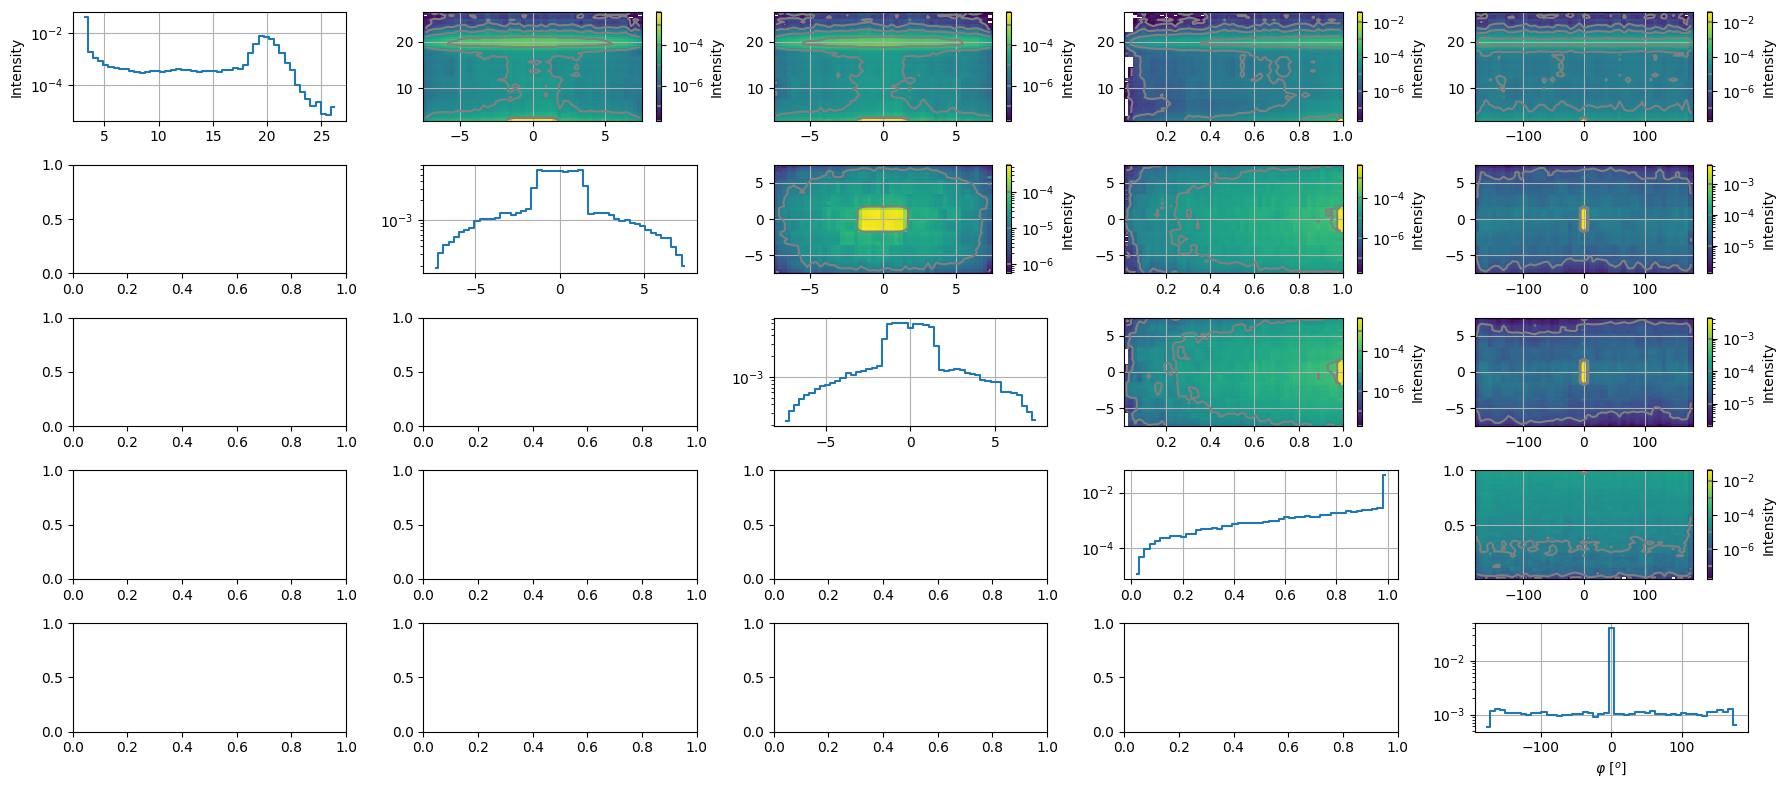

In [11]:
fig, ax_matrix = plot_pairwise_matrix(
    trackfile_resampled, vars_to_plot, bins=50,figsize=(18, 8)
)
plt.savefig("resampled_matrix.png", dpi=600, bbox_inches="tight")
plt.show()

## Comparacion entre files

### Ploteos 1D

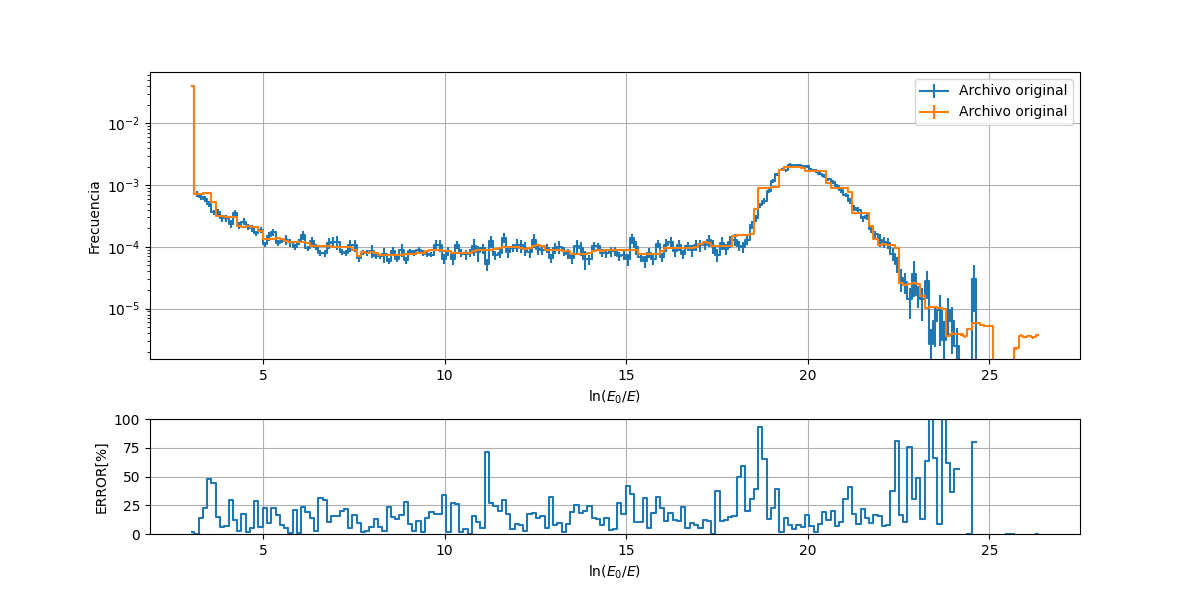

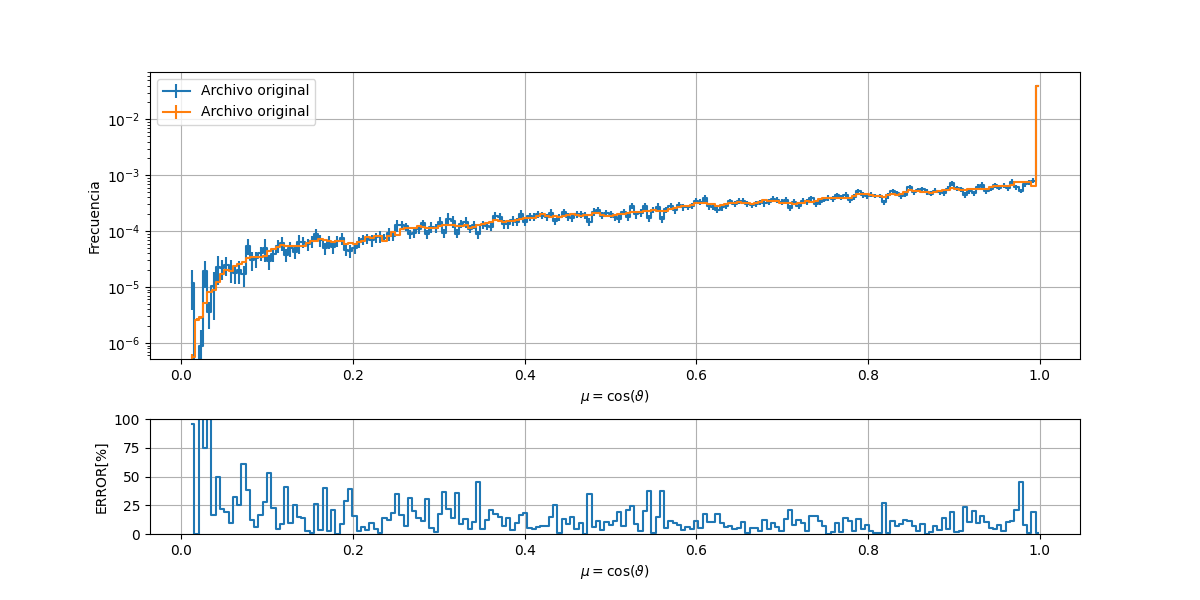

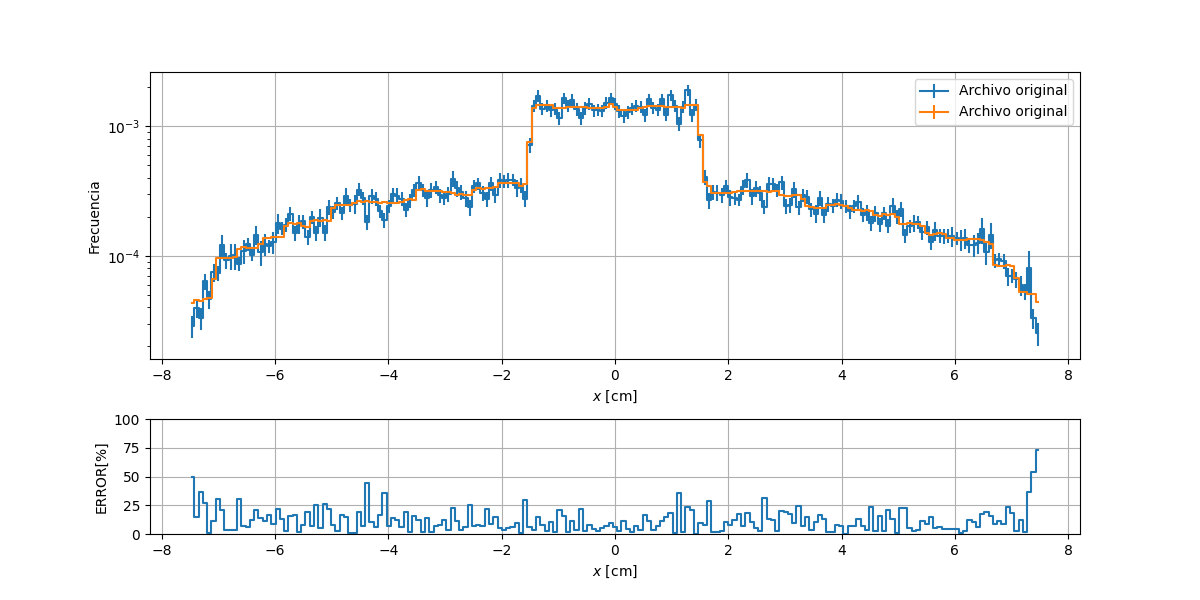

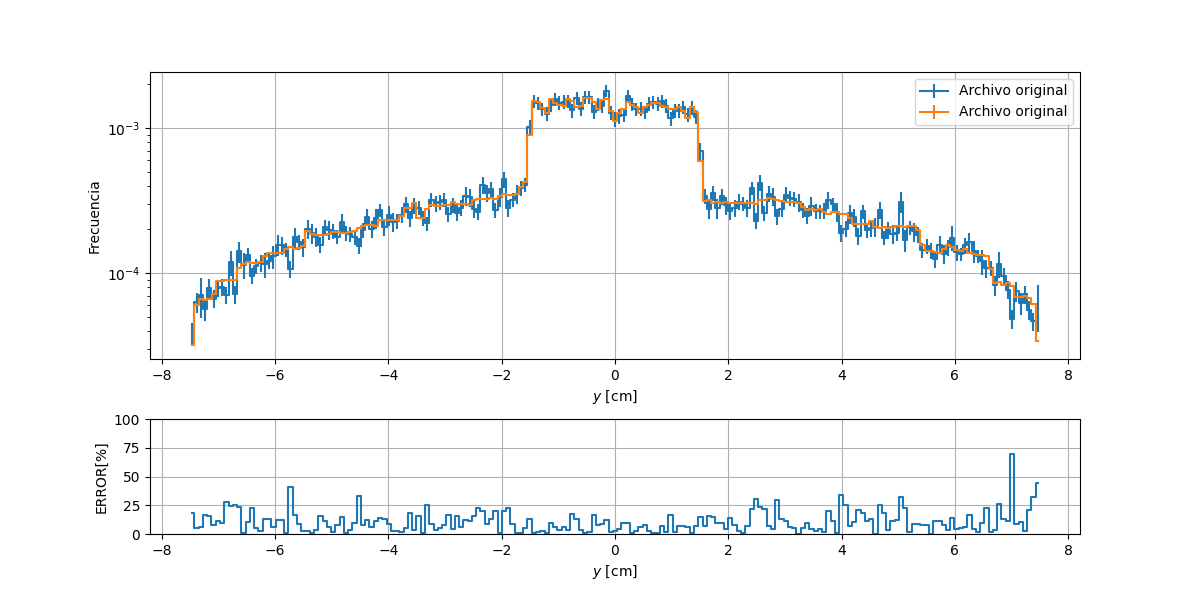

In [12]:
bins = int(200)
%matplotlib widget

plot_comparision_1D(
    "ln(E0/E)",
    trackfile_original=hs.surface_source,
    trackfile_resampled=trackfile_resampled,
    bins=bins,
    # right_xlim=4,
)
plt.savefig("fig4_10.png", dpi=600, bbox_inches="tight")
plot_comparision_1D(
    "mu",
    trackfile_original=hs.surface_source,
    trackfile_resampled=trackfile_resampled,
    # bins=2000,
    bins=bins,
    # right_xlim=4,
)
plt.savefig("fig4_11.png", dpi=600, bbox_inches="tight")
plot_comparision_1D(
    "x",
    trackfile_original=hs.surface_source,
    trackfile_resampled=trackfile_resampled,
    bins=bins,
    # bins=1000,
    # right_xlim=4,
)
plot_comparision_1D(
    "y",
    trackfile_original=hs.surface_source,
    trackfile_resampled=trackfile_resampled,
    bins=bins,
    # right_xlim=4,
)



### Ploteos 2D

In [13]:
# bins=200

# plot_comparation_2d(
#     hs.surface_source,
#     trackfile_resampled,
#     vars=["x", "y"],
#     bins=bins,
# )

# plot_comparation_2d(
#     hs.surface_source,
#     trackfile_resampled,
#     vars=["x", "ln(E0/E)"],
#     scales=["linear", "log"],
#     bins=bins,
# )
# plot_comparation_2d(
#     hs.surface_source,
#     trackfile_resampled,
#     vars=["ln(E0/E)", "y"],
#     scales=["log", "linear"],
#     bins=bins,
# )
# plot_comparation_2d(
#     hs.surface_source,
#     trackfile_resampled,
#     scales=["log", "linear"],
#     vars=["ln(E0/E)", "mu"],
#     bins=bins,
# )

### Matriz

In [14]:
# fig, ax_matrix = plot_pairwise_matrix(
#     hs.surface_source,
#     vars_to_plot,
#     bins=30,
#     figsize=(18, 8),
#     plot_difference=True,
#     Difference_to=trackfile_resampled,
# )
# plt.savefig("comparision_matrix.png", dpi=600, bbox_inches="tight")
# plt.show()

### Divergencia KL

In [15]:
# # ss_orig y ss_resp son tus SurfaceSourceFile previamente cargados
# kl_results = report_kl_divergence(
#     hs.surface_source, trackfile_resampled,
#     variables=["ln(E0/E)","x", "y", "mu", "phi"],
#     n_bins=100,
#     smooth=1e-9,
# )

In [16]:
# del hs

# trackfile_original_largo = kds.SurfaceSourceFile(
#     filepath="/home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile6/surface_source.h5",
# )

# # ss_orig y ss_resp son tus SurfaceSourceFile previamente cargados
# kl_results = report_kl_divergence(
#     # hs.surface_source, trackfile_resampled,
#     trackfile_original_largo, trackfile_resampled,
#     variables=["ln(E0/E)","x", "y", "mu", "phi"],
#     n_bins=100,
#     smooth=1e-9,
# )
